In [1]:
import os
import time
import timm
import copy
import warnings
import random
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from albumentations import (HorizontalFlip,VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise,RandomRotate90,Transpose,RandomBrightnessContrast,RandomCrop)
from albumentations.pytorch import ToTensor
import albumentations as albu
import matplotlib.image as mpi
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
img = plt.imread('Train/10023.jpg')

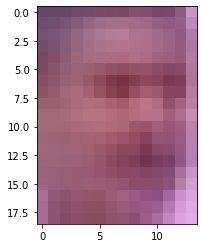

In [3]:
plt.imshow(img)

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


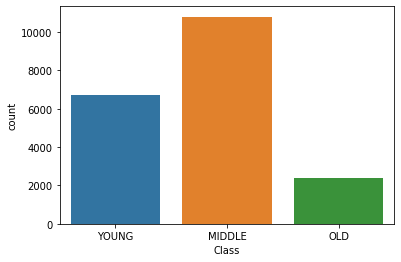

In [6]:
import seaborn as sns
sns.countplot(x = 'Class',data = df, order=['YOUNG','MIDDLE','OLD'])

In [7]:
train_df,val_df = train_test_split(df,test_size = 0.2,stratify = df['Class'])

Text(0.5, 1.0, 'Training Distribution')

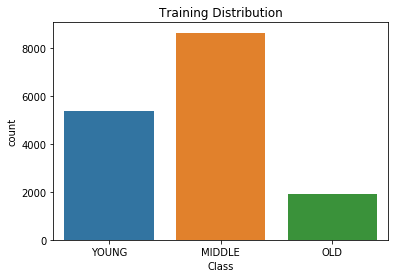

In [8]:
sns.countplot(x = 'Class',data = train_df, order=['YOUNG','MIDDLE','OLD']).set_title('Training Distribution')

Text(0.5, 1.0, 'Validation Distribution')

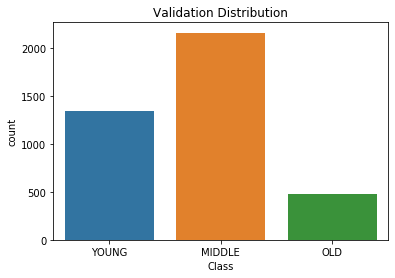

In [9]:
sns.countplot(x = 'Class',data = val_df, order=['YOUNG','MIDDLE','OLD']).set_title('Validation Distribution')

In [10]:
print(train_df.shape,val_df.shape)

(15924, 2) (3982, 2)


In [11]:
def onehot(df):
    df1 = df['Class']
    df2 = df['ID']
    df1 = pd.get_dummies(df1)
    df1 = df1[['YOUNG','MIDDLE','OLD']]
    df = pd.concat([df2,df1],axis=1)
    return df

In [12]:
train_df = onehot(train_df)
train_df.head()

,ID,YOUNG,MIDDLE,OLD
9312,18580.jpg,0,1,0
5144,18250.jpg,1,0,0
5221,6060.jpg,0,1,0
6190,26539.jpg,0,1,0
9092,9611.jpg,0,0,1


In [13]:
val_df = onehot(val_df)
val_df.head()

,ID,YOUNG,MIDDLE,OLD
2348,5748.jpg,0,1,0
4381,13321.jpg,1,0,0
17660,21743.jpg,0,1,0
8282,11314.jpg,0,1,0
2265,6637.jpg,0,1,0


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
class Age(Dataset):
    
    def __init__(self,df,phase):
        self.phase = phase
        self.df = df
        if phase == 'train':
            self.transforms = albu.Compose([
            albu.SmallestMaxSize(64),
            albu.RandomCrop(64,64),
            albu.Cutout(),
            albu.RGBShift(),
            albu.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
            ToTensor()
            ])
        elif phase == 'val':
            self.transforms = albu.Compose([
                albu.Resize(64,64),
                albu.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                ToTensor()
            ])
        elif phase == 'test':
            self.transforms = albu.Compose([
                albu.Resize(64,64),
                albu.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                ToTensor()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        label = self.df.iloc[index,1:]
        label = label.to_numpy()
        label = np.argmax(label)
        name = self.df.iloc[index,0]
        if self.phase == 'train' or 'val':
            path = 'Train/' + str(name)
        if self.phase == 'test':
            path = 'Test/' + str(name)
        img = plt.imread(path)
        img = self.transforms(image = np.array(img))
        img = img['image']
        
        return img,label

In [16]:
traindata = Age(train_df,phase = 'train')
valdata = Age(val_df,phase = 'val')

In [17]:
trainloader = DataLoader(traindata,batch_size=32)
valloader = DataLoader(valdata,batch_size = 32)

In [18]:
dataiter = iter(trainloader)
img,label = dataiter.next()
img.shape

torch.Size([32, 3, 64, 64])

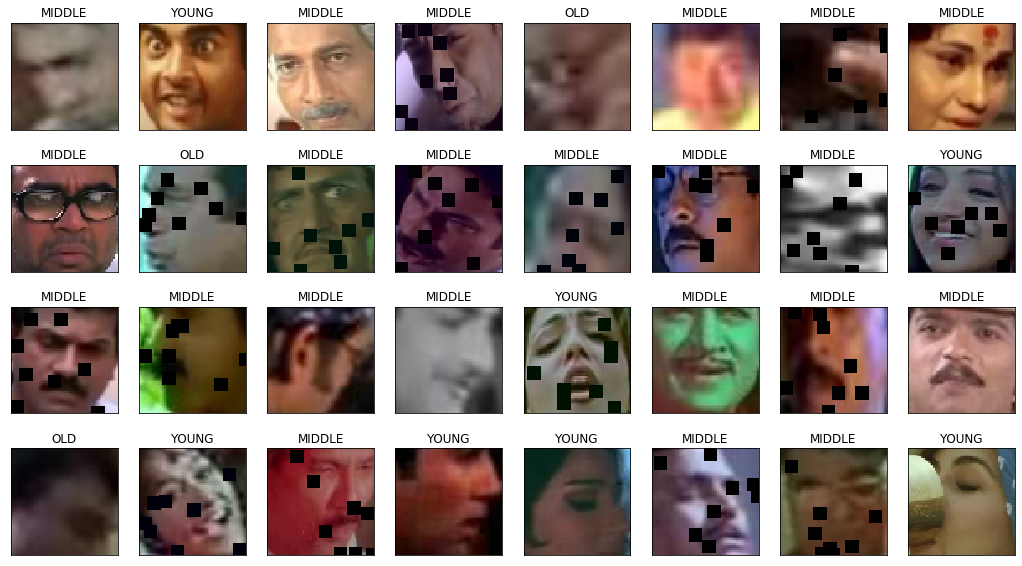

In [19]:
classes = ['YOUNG','MIDDLE','OLD']
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def im_show(img):
    npimg = img.numpy().transpose((1,2,0))*std + mean
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(npimg)
fig = plt.figure(figsize=(18,10))

for i in np.arange(32):
    ax = fig.add_subplot(4,8,i+1,xticks=[],yticks=[])
    im_show(img[i])
    ax.set_title(classes[label[i]])

In [20]:
effdet = timm.create_model('efficientnet_b0',pretrained = True,num_classes=3)

In [21]:
from pytorch_ranger import Ranger

In [23]:
optimizer = Ranger(effdet.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer,factor=0.90, mode="min", patience=4)

In [24]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [25]:
def train_model(dataloaders,model,scheduler, criterion, optimizer, num_epochs):
    since = time.time()
    dataset_sizes = {'train': len(dataloaders['train'].dataset), 
                     'val': len(dataloaders['val'].dataset)}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    number_of_iter = 0
    acc_train = []
    acc_val = []
    loss_train = []
    loss_val = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            current_loss = 0.0
            current_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]
            if phase=="train":
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                scheduler.step(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(),'best_weights.pth')
                torch.save(optimizer.state_dict(), 'optimizer.pth')

        print('Current LR: {:.6f}'.format(get_lr(optimizer)))
        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    
    
    return model,acc_val,acc_train,loss_train,loss_val


In [26]:
effdet.to(device)
dataloaders = {"train":trainloader,"val":valloader}
num_epochs=50
start_time = time.time()
model,acc_val,acc_train,loss_train,loss_val = train_model(dataloaders, effdet,scheduler, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/49
train Loss: 4.0366 Acc: 0.4713
val Loss: 1.4786 Acc: 0.5897
Current LR: 0.001000

Epoch 1/49
train Loss: 1.2221 Acc: 0.5798
val Loss: 0.7610 Acc: 0.6695
Current LR: 0.001000

Epoch 2/49
train Loss: 0.8223 Acc: 0.6488
val Loss: 0.6874 Acc: 0.7120
Current LR: 0.001000

Epoch 3/49
train Loss: 0.7359 Acc: 0.6886
val Loss: 0.6364 Acc: 0.7308
Current LR: 0.001000

Epoch 4/49
train Loss: 0.6778 Acc: 0.7114
val Loss: 0.6006 Acc: 0.7454
Current LR: 0.001000

Epoch 5/49
train Loss: 0.6290 Acc: 0.7341
val Loss: 0.5583 Acc: 0.7659
Current LR: 0.001000

Epoch 6/49
train Loss: 0.5660 Acc: 0.7638
val Loss: 0.5429 Acc: 0.7735
Current LR: 0.001000

Epoch 7/49
train Loss: 0.5053 Acc: 0.7911
val Loss: 0.5653 Acc: 0.7803
Current LR: 0.001000

Epoch 8/49
train Loss: 0.4655 Acc: 0.8098
val Loss: 0.6782 Acc: 0.7587
Current LR: 0.001000

Epoch 9/49
train Loss: 0.4091 Acc: 0.8378
val Loss: 0.5945 Acc: 0.7833
Current LR: 0.001000

Epoch 10/49
train Loss: 0.3785 Acc: 0.8509
val Loss: 0.8357 Acc: 0.762

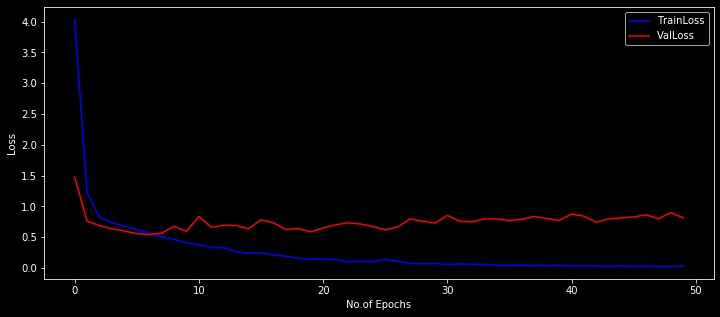

In [27]:
epoch = []
for x in range(num_epochs):
    epoch.append(x)
plt.style.use('dark_background')
fig = plt.figure(figsize = (12,5))
plt.plot(epoch,loss_train,label = 'TrainLoss',color = 'blue')
plt.plot(epoch,loss_val,label = 'ValLoss',color = 'red')
plt.xlabel('No.of Epochs')
plt.ylabel('Loss')
plt.legend()

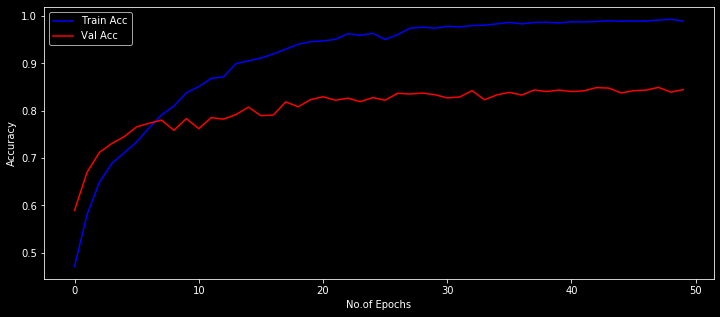

In [28]:
plt.style.use('dark_background')
fig = plt.figure(figsize = (12,5))
plt.plot(epoch,acc_train,label = 'Train Acc',color = 'blue')
plt.plot(epoch,acc_val,label = 'Val Acc',color = 'red')
plt.xlabel('No.of Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [29]:
sample = pd.read_csv('sample_submission.csv')

In [30]:
sample.head()

,Class,ID
0,MIDDLE,25321.jpg
1,MIDDLE,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


In [31]:
output = pd.DataFrame(index = sample.index,columns = sample.keys())
output['ID'] = sample['ID']

In [32]:
output.head()

,Class,ID
0,NaN,25321.jpg
1,NaN,989.jpg
2,NaN,19277.jpg
3,NaN,13093.jpg
4,NaN,5367.jpg


In [33]:
sample = sample[["ID","Class"]]
sample.head()

,ID,Class
0,25321.jpg,MIDDLE
1,989.jpg,MIDDLE
2,19277.jpg,MIDDLE
3,13093.jpg,MIDDLE
4,5367.jpg,MIDDLE


In [34]:
testdata = Age(sample,phase = 'test')

In [35]:
testloader = DataLoader(testdata,batch_size = 32)

In [37]:
dataiter = iter(testloader)
img,label = dataiter.next()
img.shape

torch.Size([32, 3, 64, 64])

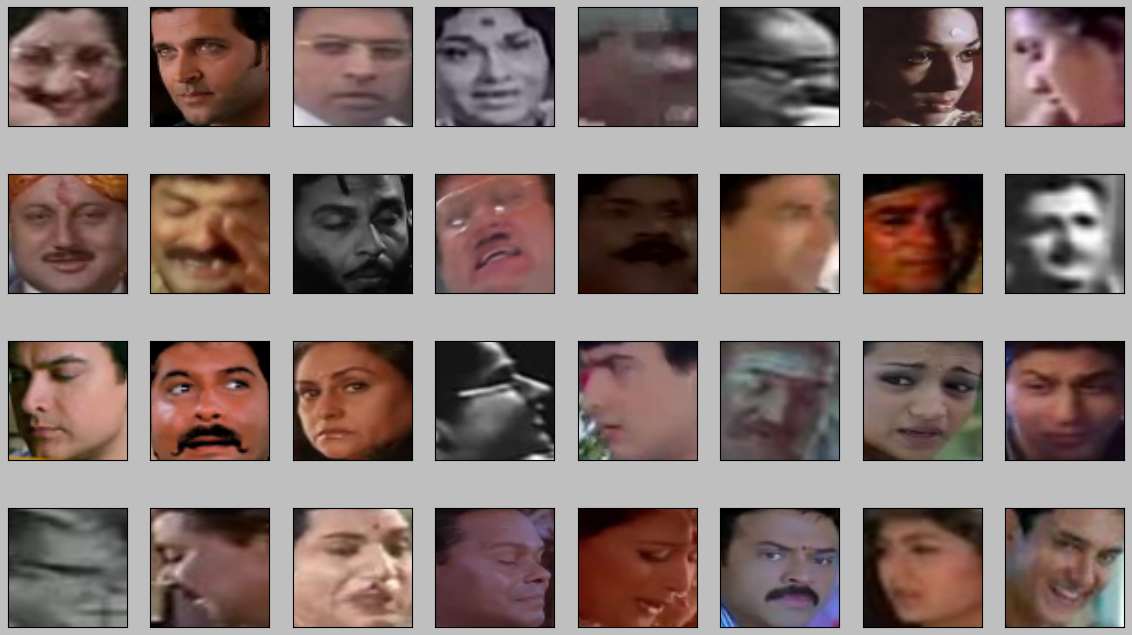

In [38]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def im_show(img):
    npimg = img.numpy().transpose((1,2,0))*std + mean
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(npimg)
plt.style.use('classic')
fig = plt.figure(figsize=(18,10))
for i in np.arange(32):
    ax = fig.add_subplot(4,8,i+1,xticks=[],yticks=[])
    im_show(img[i])

In [39]:
def test_submission(model):
    since = time.time()
    sub_output = []
    model.train(False)
    for data in testloader:
        inputs,labels = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _,pred = torch.max(outputs.data,1)
        pred = pred.data.cpu().numpy()
        sub_output.append(pred.data)
    sub_output = np.concatenate(sub_output)
    output['Class'] = sub_output
    print()
    time_elapsed = time.time() - since
    print('Run complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [40]:
test_submission(model)


Run complete in 0m 12s


In [41]:
output.head()

,Class,ID
0,1,25321.jpg
1,0,989.jpg
2,2,19277.jpg
3,1,13093.jpg
4,1,5367.jpg


In [42]:
d = {0:'YOUNG',1:'MIDDLE',2:'OLD'}
output['Class'] = output['Class'].map(d)
output.head()

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,OLD,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


In [43]:
output.to_csv('50epocheffdetb0.csv',index=False)